In [81]:
import os.path as osp

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer

from tqdm import tqdm

dataset = 'Cora'
path = osp.join('data', 'Planetoid')
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.linear = torch.nn.Linear(16, dataset.num_features)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.linear(x)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

pbar = tqdm(range(1000))
for epoch in pbar:
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    pbar.set_description("Loss -> %.5f" % loss.item())
model.eval()

Loss -> 0.04788: 100%|██████████| 1000/1000 [00:41<00:00, 24.34it/s]


Net(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 16)
  (linear): Linear(in_features=16, out_features=1433, bias=True)
)

Explain node 10: 100%|██████████| 200/200 [00:00<00:00, 409.53it/s]


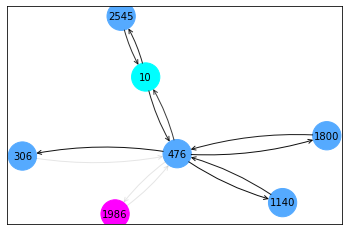

In [82]:
explainer = GNNExplainer(model, epochs=200)
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

In [106]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pyro
import pyro.distributions as dist

from torch_geometric.utils import k_hop_subgraph

n_hops = 2
subset, edge_index_adj, mapping, edge_mask_hard = k_hop_subgraph(
        node_idx, n_hops, edge_index, relabel_nodes=True)
x_adj = x[subset]

with torch.no_grad():
    preds = model(x, edge_index_adj)
    pred_labels = preds.argmax(dim=-1)

In [107]:
import torch.distributions.constraints as constraints
N = edge_index_adj.size(1)

def sample_model(X, y):
    alpha = torch.tensor([2.0 for i in range(N)])
    beta = torch.tensor([4.0 for i in range(N)])
    m = torch.zeros(N)
    for i in range(N):
        f = pyro.sample("f_%d" % i, dist.Beta(alpha[i], beta[i]))
        m[i] = pyro.sample("m_%d" % i, dist.Bernoulli(f))
    mean = model(X, edge_index_adj[:, m == 1])[mapping].reshape(-1)
    y_sample = pyro.sample("y", dist.MultivariateNormal(mean, 0.01 * torch.eye(mean.size(0))), obs = y)
    
def sample_guide(X, y):
    alpha_q = pyro.param("alpha_q", torch.tensor([2.0 for i in range(N)]), constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor([4.0 for i in range(N)]), constraint=constraints.positive)
    m = torch.zeros(N)
    for i in range(N):
        f = pyro.sample("f_%d" % i, dist.Beta(alpha_q[i], beta_q[i]))
        m[i] = pyro.sample("m_%d" % i, dist.Bernoulli(f))

In [143]:
def ma(l, window):
    cumsum, moving_aves = [0], []

    for i, x in enumerate(l, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=window:
            moving_ave = (cumsum[i] - cumsum[i-window])/window
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
    return moving_aves

In [149]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

adam_params = {"lr": 0.0005, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
# setup the inference algorithm
svi = SVI(sample_model, sample_guide, optimizer, loss=Trace_ELBO())

n_steps = 5000
window = 1000
# do gradient steps
pbar = tqdm(range(n_steps))
elbos = []
for step in pbar:
    elbo = svi.step(x_adj, preds[mapping[0]])
    elbos.append(elbo)
    avgs = ma(elbos, window)
    if step >= window:
        disp = avgs[-1]
    else:
        disp = elbo
    pbar.set_description("Loss -> %.4f" % disp)

Loss -> 13553.0631: 100%|██████████| 5000/5000 [03:39<00:00, 22.76it/s] 


<AxesSubplot:>

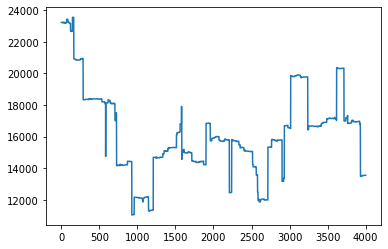

In [150]:
sns.lineplot(x=range(len(avgs)), y=avgs)

In [146]:
alpha = pyro.param('alpha_q')
beta = pyro.param('beta_q')

In [147]:
dist.Beta(alpha, beta).mean

tensor([0.3305, 0.6846, 0.0033, 0.9985, 0.4009, 0.1347, 0.4847, 0.9949, 0.0799,
        0.0028, 0.9978, 0.0018], grad_fn=<DivBackward0>)

In [148]:
edge_mask[edge_mask_hard]

tensor([0.8473, 0.8480, 0.0509, 0.7547, 0.9313, 0.9338, 0.9314, 0.0749, 0.8934,
        0.8886, 0.0888, 0.8100])